In [679]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax as true_softmax

from sklearn.linear_model import LogisticRegressionCV

In [800]:
class function:

  def __init__(self, function, derivative):
    self.function = function
    self.derivative = derivative

relu = function(
    function=lambda x: max(x, 0),
    derivative=lambda x: int(x>=0)

)
sigmoid = function(
  function = lambda x: 1/(1 + np.exp(-x)),
  derivative = lambda x: 1/(1 + np.exp(-x)) * (1 - 1/(1 + np.exp(-x)))
)

softmax = function(
    function=true_softmax,
    derivative=lambda x: np.diag(x) - x.reshape(-1, 1) @ x.reshape(1, -1)
)
cross_entropy = function(
    function=lambda y, y_pred: -np.sum(np.where(y==1, np.log(y_pred), 0)),
    derivative=lambda y, y_pred: -np.where(y==1, 1/(y_pred+1e-4), 0)
)

class perceptron_layer:

  def __init__(self, dim, w=None, b=None, activation=relu):
    self.dim = dim
    if w is None:
      self.w = np.random.normal(size=dim, scale=0.5)
    else:
      assert w.shape[0] == dim[0]
      assert w.shape[1] == dim[1] 
      self.w = w
    if b is None:
      self.b = np.random.normal(size=dim[0], scale=0.5)
    else:
      assert len(b) == dim[0]
      self.b = b
    self.activation_function = np.vectorize(activation.function)
    self.activation_derivative = np.vectorize(activation.derivative)
    self.input = None
    self.output_before_activation = None
    self.gradient_b = np.zeros(shape=dim[0])
    self.gradient_w = np.zeros(shape=dim)

  def forward_pass(self, input):
    self.input = input
    self.output_before_activation = self.w @ self.input + self.b
    return self.activation_function(self.output_before_activation)

  def backward_pass(self, grad_output):
    self.gradient_b = self.gradient_b + grad_output * self.activation_derivative(self.output_before_activation)
    self.gradient_w = self.gradient_w + grad_output.reshape(-1, 1) @ self.input.reshape(1, -1)
    grad_input = self.gradient_b @ self.w
    assert not np.isnan(self.gradient_b).any()
    assert not np.isnan(self.gradient_w).any()
    return grad_input
  
  def update_params(self, learning_rate=0.01):
    self.b = self.b - learning_rate * self.gradient_b
    self.w = self.w - learning_rate * self.gradient_w
    self.gradient_b = np.zeros(shape=self.dim[0])
    self.gradient_w = np.zeros(shape=self.dim)
    assert not np.isnan(self.w).any()
    assert not np.isnan(self.b).any()

class mlp:

  def __init__(self, output_transform=softmax, loss=cross_entropy, learning_rate=0.01):
    self.layers = []
    self.output_transform=output_transform
    self.loss = loss
    self.output_raw = None
    self.y_pred = None
    self.learning_rate=learning_rate
    self.training_history={
        'train_loss': [],
        'test_loss': [],
        'test_accuracy': [],
    }

  def add_layer(self, layer):
    if len(self.layers) > 0:
      assert layer.dim[1] == self.layers[-1].dim[0]
    self.layers.append(layer)

  def forward_pass(self, x):
    output = x
    for i in range(len(self.layers)):
      output = self.layers[i].forward_pass(output)
    self.output_raw = output
    if self.output_transform is not None:
      output = self.output_transform.function(output)
    self.y_pred = output
    return self.y_pred
    
  def backward_pass(self, y):
    gradient = self.output_transform.derivative(self.y_pred) @ self.loss.derivative(y, self.y_pred)
    for i in range(len(self.layers)-1, -1, -1):
      gradient = self.layers[i].backward_pass(gradient)

  def update_params(self):
    for layer in self.layers:
      layer.update_params(learning_rate=self.learning_rate)

  def fit(self, X_train, y_train, *, X_test=None, y_test=None, epochs=5, batch_size=5,):
    for epoch in range(epochs):
      predictions = []
      true = []
      loss = []
      for i in range(len(X_train)):
        y_pred = self.forward_pass(X_train[i])
        self.backward_pass(y_train[i])
        predictions.append(y_pred)
        true.append(y_train[i])
        loss.append(cross_entropy.function(y_train[i], y_pred))
        if i%batch_size==0:
          self.update_params()
        self.update_params()
      train_loss = np.mean(loss)
      test_loss = log_loss(enc.transform(y_test), self.predict_proba(X_test)) #BAD CODING!!!
      test_accuracy = accuracy_score(y_test, self.predict(X_test)).round(2)
      print(f"Epoch {epoch} - train_loss: {train_loss.round(4)}, test_loss: {test_loss}, test_accuracy:{test_accuracy.round(2)}")
      self.training_history['train_loss'].append(train_loss)
      self.training_history['test_loss'].append(test_loss)
      self.training_history['test_accuracy'].append(test_accuracy)
      
  def predict(self, X):
    predictions = []
    for x in X:
      predictions.append(np.argmax(self.forward_pass(x)))
    return predictions

  def predict_proba(self, X):
    predictions = []
    for x in X:
      predictions.append(self.forward_pass(x))
    return np.array(predictions)

In [758]:
# Load data
df = load_digits()
X = df['data']/16
y = df['target'].reshape(-1, 1)
enc = OneHotEncoder(sparse=False)
enc.fit(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Label: 0


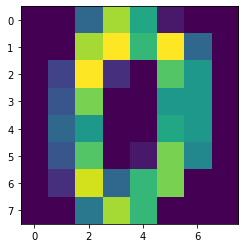

In [840]:
plt.imshow(X[0].reshape(8, 8))
print('Label:', y[0][0]);

# **Baseline model - Logistic regression with cross-validation**

In [ ]:
logit = LogisticRegressionCV(multi_class='multinomial', solver='sag')
logit.fit(X_train, y_train)

In [841]:
y_pred = logit.predict(X_test)
y_prob = logit.predict_proba(X_test)
print(f"""
  Logit results
  Test accuracy: {accuracy_score(y_test, y_pred).round(2)}
  Test log-loss: {log_loss(enc.transform(y_test), y_prob).round(3)}
""")


  Logit results
  Test accuracy: 0.96
  Test log-loss: 0.093



# **Multilayer perceptron**

In [831]:
model = mlp(learning_rate=0.005)
model.add_layer(perceptron_layer([32, 64]))
model.add_layer(perceptron_layer([10, 32]))

In [832]:
# Training
model.fit(X_train, enc.transform(y_train), X_test=X_test, y_test=y_test, epochs=100, batch_size=10)

Epoch 0 - train_loss: 1.5528, test_loss: 0.8345872717348969, test_accuracy:0.73
Epoch 1 - train_loss: 0.6263, test_loss: 0.45032345453477585, test_accuracy:0.87
Epoch 2 - train_loss: 0.4016, test_loss: 0.35167732742143204, test_accuracy:0.87
Epoch 3 - train_loss: 0.3207, test_loss: 0.32146375270676275, test_accuracy:0.89
Epoch 4 - train_loss: 0.2694, test_loss: 0.26643127570471725, test_accuracy:0.9
Epoch 5 - train_loss: 0.2394, test_loss: 0.24823816849878189, test_accuracy:0.91
Epoch 6 - train_loss: 0.2167, test_loss: 0.21748362853223357, test_accuracy:0.92
Epoch 7 - train_loss: 0.1933, test_loss: 0.20402868404024133, test_accuracy:0.92
Epoch 8 - train_loss: 0.1826, test_loss: 0.19331225273456532, test_accuracy:0.93
Epoch 9 - train_loss: 0.1696, test_loss: 0.18492723313419193, test_accuracy:0.94
Epoch 10 - train_loss: 0.1572, test_loss: 0.1826961096782824, test_accuracy:0.94
Epoch 11 - train_loss: 0.1477, test_loss: 0.1721863481857014, test_accuracy:0.95
Epoch 12 - train_loss: 0.1437,

In [833]:
print(f"""
  MLP results
  Test accuracy: {accuracy_score(y_test, model.predict(X_test)).round(2)}
  Test log-loss: {log_loss(enc.transform(y_test), model.predict_proba(X_test)).round(3)}
""")


  MLP results
  Test accuracy: 0.97
  Test log-loss: 0.108



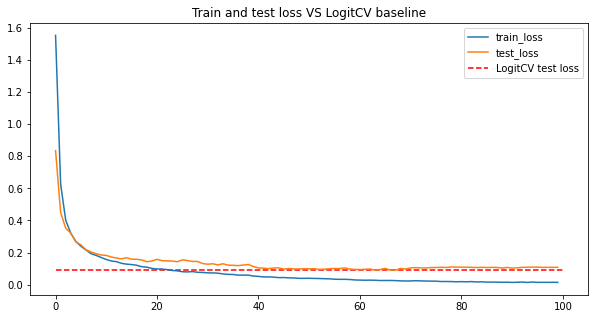

In [842]:
fig = plt.figure(figsize=(10, 5))
plt.plot(model.training_history['train_loss'], label='train_loss')
plt.plot(model.training_history['test_loss'], label='test_loss')
plt.hlines(
    log_loss(enc.transform(y_test),logit.predict_proba(X_test)).round(3),
    xmin=0,
    xmax=100,
    label='LogitCV test loss', color='r',
    linestyles='dashed'
)
plt.title('Train and test loss VS LogitCV baseline')
plt.legend()
plt.show()